# Working with historical tonnage lists

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key, acquired here: [https://apis.signalocean.com/profile](https://apis.signalocean.com/profile)

In [1]:
signal_ocean_api_key = ""  # replace with your subscription key


## Retrieving a historical tonnage list
First, we need to create an instance of the `TonnageListAPI`:

In [2]:
from signal_ocean import Connection
from signal_ocean.tonnage_list import TonnageListAPI

connection = Connection(signal_ocean_api_key)
api = TonnageListAPI(connection)



Then, we need to determine the parameters of the **historical tonnage list** (**HTL**). In order to fetch an HTL, we will need to specify:
- a loading port,
- a vessel class,
- a time frame.

Ports and vessel classes can be retrieved through the `get_ports` and `get_vessel_classes` methods:

In [3]:
api.get_vessel_classes()


(VesselClass(id=60, name='VLGCLpg'),
 VesselClass(id=61, name='MidsizeLpg'),
 VesselClass(id=62, name='HandyLpg'),
 VesselClass(id=63, name='SmallLpg'),
 VesselClass(id=69, name='VLOC'),
 VesselClass(id=70, name='Capesize'),
 VesselClass(id=72, name='PostPanamaxDry'),
 VesselClass(id=74, name='PanamaxDry'),
 VesselClass(id=75, name='Supramax'),
 VesselClass(id=76, name='Handymax'),
 VesselClass(id=77, name='Handysize'),
 VesselClass(id=78, name='ULCV'),
 VesselClass(id=79, name='NewPanamaxContainer'),
 VesselClass(id=80, name='PostPanamaxContainer'),
 VesselClass(id=81, name='PanamaxContainer'),
 VesselClass(id=82, name='FeedermaxContainer'),
 VesselClass(id=83, name='FeederContainer'),
 VesselClass(id=84, name='VLCC'),
 VesselClass(id=85, name='Suezmax'),
 VesselClass(id=86, name='Aframax'),
 VesselClass(id=87, name='PanamaxTanker'),
 VesselClass(id=88, name='MR2'),
 VesselClass(id=89, name='MR1'),
 VesselClass(id=90, name='Small'),
 VesselClass(id=91, name='LNGLng'),
 VesselClass(id=

Ports can be looked up by their name using the `PortFilter`:

In [4]:
from signal_ocean.tonnage_list import PortFilter

api.get_ports(PortFilter(name_like="rot"))


(Port(id=3689, name='Rotterdam'),
 Port(id=6625, name='Rota'),
 Port(id=8920, name='Crotone'),
 Port(id=15617, name='Rarotonga'))

And so can vessel classes with the use of the `VesselClassFilter`:

In [5]:
from signal_ocean.tonnage_list import VesselClassFilter

api.get_vessel_classes(VesselClassFilter(name_like="MAX"))


(VesselClass(id=72, name='PostPanamaxDry'),
 VesselClass(id=74, name='PanamaxDry'),
 VesselClass(id=75, name='Supramax'),
 VesselClass(id=76, name='Handymax'),
 VesselClass(id=79, name='NewPanamaxContainer'),
 VesselClass(id=80, name='PostPanamaxContainer'),
 VesselClass(id=81, name='PanamaxContainer'),
 VesselClass(id=82, name='FeedermaxContainer'),
 VesselClass(id=85, name='Suezmax'),
 VesselClass(id=86, name='Aframax'),
 VesselClass(id=87, name='PanamaxTanker'))

Note that the search is case-insensitive and does not require specifying exact names.

We want our HTL to contain Aframax vessels in Ceyhan, with a 6-day forward laycan end, for the last 90 days:

In [6]:
from datetime import timedelta, date

vessel_class_filter = VesselClassFilter(name_like="aframax")
vessel_class = api.get_vessel_classes(vessel_class_filter)[0]

port_filter = PortFilter(name_like="ceyhan")
port = api.get_ports(port_filter)[0]

laycan_end_in_days = 6
today = date.today()
start_date = today - timedelta(days=5)


With the parameters above, we can now request an HTL:

In [7]:
from signal_ocean.tonnage_list import DateRange

htl = api.get_historical_tonnage_list(
    port, vessel_class, laycan_end_in_days, DateRange(start_date, today)
)


The resulting historical tonnage list is a Python object that contains a collection of tonnage lists, each of which has a timestamp and a collection of vessel data. The tonnage lists are ordered by date in descending order:

In [8]:
yesterdays_tl = htl[1]
print("Date:", yesterdays_tl.date)
print("Vessel count:", len(yesterdays_tl.vessels))
print("Example vessel:", yesterdays_tl.vessels[0])


Date: 2021-10-06 12:00:00+00:00
Vessel count: 77
Example vessel: Vessel(imo=9486910, name='Beta', vessel_class='Aframax', ice_class=None, year_built=2010, deadweight=105319, length_overall=228.6, breadth_extreme=42, market_deployment='Contract', push_type='Not Pushed', open_port='Rotterdam', open_date=datetime.datetime(2019, 10, 15, 12, 37, 38, 306000, tzinfo=datetime.timezone.utc), operational_status='Laden', commercial_operator='Held Maritime Shipping', commercial_status='Available', eta=datetime.datetime(2019, 10, 27, 9, 0, tzinfo=datetime.timezone.utc), latest_ais=datetime.datetime(2019, 10, 13, 4, 47, 29, tzinfo=datetime.timezone.utc), subclass='Dirty', willing_to_switch_subclass=False, open_prediction_accuracy='Narrow Area', open_areas=(Area(name='Continent', location_taxonomy='Narrow Area'), Area(name='UK Continent', location_taxonomy='Wide Area'), Area(name='Netherlands', location_taxonomy='Country')), availability_port_type='Prediction', availability_date_type='Prediction')


The result can also be converted into a Pandas data frame:

In [9]:
data_frame = htl.to_data_frame()
data_frame

name vessel_class ice_class  \
date                      imo                                               
2021-10-06 12:00:00+00:00 9486910             Beta      Aframax       NaN   
                          9138604  Barakuda Natuna      Aframax       NaN   
                          9038830           Proteo      Aframax       NaN   
                          8508292    Gunung Kemala      Aframax       NaN   
                          9038854     Warrior King      Aframax       NaN   
...                                            ...          ...       ...   
2021-10-02 12:00:00+00:00 9249116      Elka Athina      Aframax       NaN   
                          9416551           Alatau      Aframax       NaN   
                          9417311        Vallesina      Aframax       NaN   
                          9528043          Daytona      Aframax       NaN   
                          9752797     Alfa Alandia      Aframax       NaN   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2021-10-06 12:00:00+00:00 9486910        2010      105319          228.60   
                          9138604        1998      109277          244.60   
                          9038830        1993       99392          243.97   
                          8508292        1986       86962          242.00   
                          9038854        1993       99371          243.97   
...                                       ...         ...             ...   
2021-10-02 12:00:00+00:00 9249116        2005      101970          243.60   
                          9416551        2009      115896          248.96   
                          9417311        2009      109060          243.00   
                          9528043        2011      115896          248.97   
                          9752797        2016      106324          228.00   

                                   breadth_extreme subclass  \
date                      imo                                 
2021-10-06 12:00:00+00:00 9486910               42    Dirty   
                          9138604               42    Clean   
                          9038830               46    Dirty   
                          8508292               42    Dirty   
                          9038854               46    Dirty   
...                                            ...      ...   
2021-10-02 12:00:00+00:00 9249116               42    Clean   
                          9416551               44    Dirty   
                          9417311               42    Dirty   
                          9528043               44    Dirty   
                          9752797               42    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2021-10-06 12:00:00+00:00 9486910                        Contract   
                          9138604                            Spot   
                          9038830                         Program   
                          8508292                         Program   
                          9038854                         Program   
...                                                           ...   
2021-10-02 12:00:00+00:00 9249116                            Spot   
                          9416551                            Spot   
                          9417311                         Program   
                          9528043                            Spot   
                          9752797                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2021-10-06 12:00:00+00:00 9486910              Not Pushed  ...   
                          9138604              Not Pushed  ...   
                          9038830              Not Pushed  .

## Example 1 - Plotting a supply trend
The data frame format makes it very easy to generate a supply trend plot.

We'll generate a supply trend from the beginning of the year, but we'll also filter the vessel list by looking for vessels that:
- are pushed,
- have a market deployment type of "Relet" or "Spot",
- their commercial status is available, cancelled or failed,
- are crude oil tankers (their vessel subclass is "Dirty"),
- their AIS information is no older than 5 days.

Filtering can be achieved by creating an instance of a `VesselFilter` and passing it to the `get_historical_tonnage_list` method. A `VesselFilter` meeting the above criteria will look as follows:

In [10]:
from signal_ocean.tonnage_list import (
    VesselFilter,
    PushType,
    MarketDeployment,
    CommercialStatus,
    VesselSubclass,
)

vessel_filter = VesselFilter(
    push_types=[PushType.PUSHED],
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT],
    commercial_statuses=[
        CommercialStatus.AVAILABLE,
        CommercialStatus.CANCELLED,
        CommercialStatus.FAILED,
    ],
    vessel_subclass=VesselSubclass.DIRTY,
    latest_ais_since=5,
)


Note the usage of the `PushType`, `MarketDeployment`, `CommercialStatus`, and `VesselSubclass`. These are enum-like classes that contain constants for all the possible values for a given `VesselFilter` parameter. To list the available values for any of the classes, just invoke `list()` on the class:

In [11]:
list(CommercialStatus)

['On Subs', 'Failed', 'Cancelled', 'Available', 'Poss Fixed']

You can use these values directly or use a corresponding class member:

In [12]:
CommercialStatus.ON_SUBS == 'On Subs'

True

Let's get the HTL for our filter:

In [13]:
beginning_of_year = date(today.year, 1, 1)

htl_for_supply_trend = api.get_historical_tonnage_list(
    port,
    vessel_class,
    laycan_end_in_days,
    DateRange(start_date, today),
    vessel_filter=vessel_filter,
)

supply_trend_data_frame = htl_for_supply_trend.to_data_frame()
supply_trend_data_frame


name vessel_class ice_class  \
date                      imo                                                
2021-10-06 12:00:00+00:00 9395331          Corossol      Aframax       NaN   
                          9522128            Calida      Aframax       NaN   
                          9749556             Balla      Aframax       NaN   
                          9288710     Delta Captain      Aframax        1A   
                          9384069            Saetta      Aframax       NaN   
...                                             ...          ...       ...   
2021-10-02 12:00:00+00:00 9384992         Guanabara      Aframax       NaN   
                          9592276            Stamos      Aframax       NaN   
                          9343340        Gemini Sun      Aframax       NaN   
                          9276573  Minerva Eleonora      Aframax        1C   
                          9384069            Saetta      Aframax       NaN   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2021-10-06 12:00:00+00:00 9395331        2010      106898         243.800   
                          9522128        2012      115812         248.971   
                          9749556        2017      113293         250.000   
                          9288710        2005      111009         250.000   
                          9384069        2009      107023         243.800   
...                                       ...         ...             ...   
2021-10-02 12:00:00+00:00 9384992        2007      106045         240.500   
                          9592276        2012      115666         248.970   
                          9343340        2008      115577         243.800   
                          9276573        2004      103622         244.000   
                          9384069        2009      107023         243.800   

                                   breadth_extreme subclass  \
date                      imo                                 
2021-10-06 12:00:00+00:00 9395331               42    Dirty   
                          9522128               44    Dirty   
                          9749556               44    Dirty   
                          9288710               44    Dirty   
                          9384069               42    Dirty   
...                                            ...      ...   
2021-10-02 12:00:00+00:00 9384992               42    Dirty   
                          9592276               44    Dirty   
                          9343340               42    Dirty   
                          9276573               42    Dirty   
                          9384069               42    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2021-10-06 12:00:00+00:00 9395331                            Spot   
                          9522128                            Spot   
                          9749556                            Spot   
                          9288710                            Spot   
                          9384069                            Spot   
...                                                           ...   
2021-10-02 12:00:00+00:00 9384992                           Relet   
                          9592276                            Spot   
                          9343340                            Spot   
                          9276573                            Spot   
                          9384069                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2021-10-06 12:00:00+00:00 9395331                  Pushed  ...   
                          9522128                  Pushed  ...   
                          9749556               

Now, we can generate the plot:

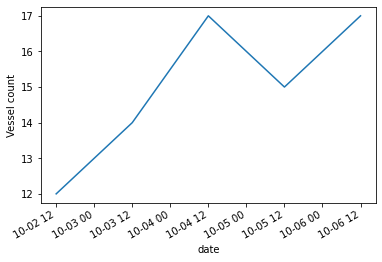

In [14]:
from signal_ocean.tonnage_list import IndexLevel

supply_trend = supply_trend_data_frame.groupby(
    IndexLevel.DATE, sort=True
).size()

plot = supply_trend.plot()
plot.set_ylabel("Vessel count")
plot


## Example 2 - Generating an Excel sheet
The data frame can be easily saved as an Excel file by using Pandas's built-in `to_excel()` function.

Before we do that, we need to remove all the time zone information from all timestamps in the data frame. This is because Excel does not support storing time zone information along with timestamps. However, Signal Ocean's SDK always provides time zone information to make all timestamp-based computation unambiguous.

In [15]:
from signal_ocean.tonnage_list import Column

without_time_zones = (
    supply_trend_data_frame.reset_index()
    .astype(
        {
            IndexLevel.DATE: "datetime64[ns]",
            Column.OPEN_DATE: "datetime64[ns]",
            Column.ETA: "datetime64[ns]",
            Column.LATEST_AIS: "datetime64[ns]",
        }
    )
    .set_index([IndexLevel.DATE, IndexLevel.IMO])
)


Now, we can generate the Excel file:

In [16]:
without_time_zones.to_excel('htl.xlsx')